In [107]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from imblearn.combine import SMOTETomek
from collections import Counter
import joblib

# Ignoring warnings
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
#Load dataset
df = pd.read_csv('adult.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
#Number of rows and features in the data set
print(f'rows: {df.shape[0]}')
print(f'features: {df.shape[1]}')

rows: 32561
features: 15


In [5]:
#Checking data types of all features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  country         32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
#Checking null values
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
country           0
salary            0
dtype: int64

In [7]:
df['salary'].value_counts(normalize = True)

 <=50K    0.75919
 >50K     0.24081
Name: salary, dtype: float64

In [8]:
cat_features = [column for column in df.columns if df[column].dtype == 'O']
num_features = [column for column in df.columns if df[column].dtype != 'O']

In [9]:
for feature in cat_features:
    print(f'{feature}\n')
    print(f'{df[feature].value_counts(normalize = True)}\n')

workclass

 Private             0.697030
 Self-emp-not-inc    0.078038
 Local-gov           0.064279
 ?                   0.056386
 State-gov           0.039864
 Self-emp-inc        0.034274
 Federal-gov         0.029483
 Without-pay         0.000430
 Never-worked        0.000215
Name: workclass, dtype: float64

education

 HS-grad         0.322502
 Some-college    0.223918
 Bachelors       0.164461
 Masters         0.052916
 Assoc-voc       0.042443
 11th            0.036086
 Assoc-acdm      0.032769
 10th            0.028654
 7th-8th         0.019840
 Prof-school     0.017690
 9th             0.015786
 12th            0.013298
 Doctorate       0.012684
 5th-6th         0.010227
 1st-4th         0.005160
 Preschool       0.001566
Name: education, dtype: float64

marital-status

 Married-civ-spouse       0.459937
 Never-married            0.328092
 Divorced                 0.136452
 Separated                0.031479
 Widowed                  0.030497
 Married-spouse-absent    0.012837


In [10]:
for feature in cat_features:
    print(f'{feature} has: {len(df[feature].unique())} labels')

workclass has: 9 labels
education has: 16 labels
marital-status has: 7 labels
occupation has: 15 labels
relationship has: 6 labels
race has: 5 labels
sex has: 2 labels
country has: 42 labels
salary has: 2 labels


Country feature has more labels

In [11]:
df['sex'].unique()

array([' Male', ' Female'], dtype=object)

<AxesSubplot:xlabel='sex', ylabel='count'>

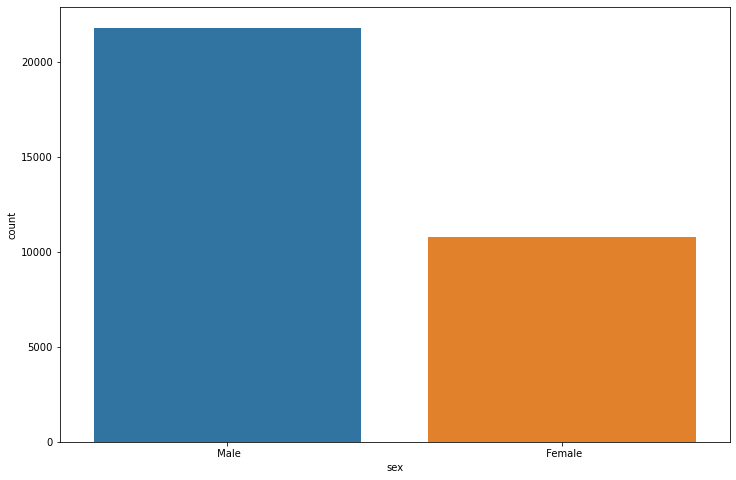

In [12]:
plt.figure(figsize = (12, 8))
sns.countplot(data = df, x = df['sex'])

As sex feature is ordinal data we will perform label encoding on sex feature

In [13]:
#Assigning 1 to Male and 0 to Female
df.replace(to_replace = [' Male', ' Female'], value = [1, 0], inplace = True)

In [14]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,<=50K


<AxesSubplot:xlabel='workclass', ylabel='count'>

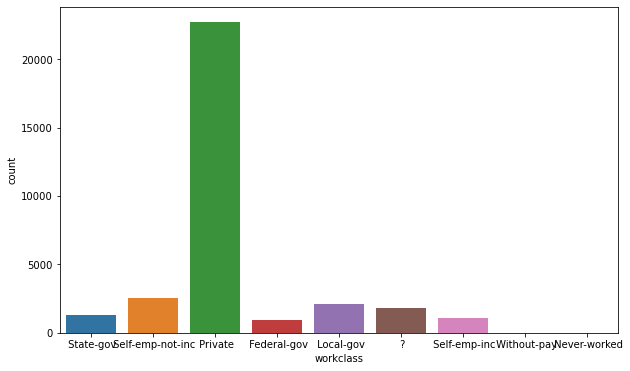

In [15]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = df['workclass'])

As we see people working in private sector count is more and there is no such order, so we perform
one hot encoding on workclass feature

In [16]:
df['workclass'].value_counts(normalize = True)*100

 Private             69.703019
 Self-emp-not-inc     7.803814
 Local-gov            6.427935
 ?                    5.638647
 State-gov            3.986364
 Self-emp-inc         3.427413
 Federal-gov          2.948312
 Without-pay          0.042996
 Never-worked         0.021498
Name: workclass, dtype: float64

Let's replace ? with most frequent label which is private

In [17]:
df.replace(to_replace = [' ?'], value = [' Private'], inplace = True)

In [18]:
df['workclass'].value_counts(normalize = True)*100

 Private             75.341666
 Self-emp-not-inc     7.803814
 Local-gov            6.427935
 State-gov            3.986364
 Self-emp-inc         3.427413
 Federal-gov          2.948312
 Without-pay          0.042996
 Never-worked         0.021498
Name: workclass, dtype: float64

Let's replace labels with less than 2% with others label

In [19]:
df.replace(to_replace = [' Without-pay', ' Never-worked'], value = ['No-Income', 'No-Income'], inplace = True)

In [20]:
df['workclass'].value_counts()

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
No-Income               21
Name: workclass, dtype: int64

In [21]:
workclass_cols = pd.get_dummies(df['workclass'], drop_first = True)

In [22]:
workclass_cols.columns

Index([' Local-gov', ' Private', ' Self-emp-inc', ' Self-emp-not-inc',
       ' State-gov', 'No-Income'],
      dtype='object')

In [23]:
df['education'].value_counts(normalize = True)*100

 HS-grad         32.250238
 Some-college    22.391818
 Bachelors       16.446055
 Masters          5.291607
 Assoc-voc        4.244341
 11th             3.608612
 Assoc-acdm       3.276926
 10th             2.865391
 7th-8th          1.983969
 Prof-school      1.768987
 9th              1.578576
 12th             1.329812
 Doctorate        1.268389
 5th-6th          1.022696
 1st-4th          0.515955
 Preschool        0.156629
Name: education, dtype: float64

In [24]:
df['education'] = df['education'].apply(lambda x : 'Primary-School' if x == ' Preschool' or x == ' 1st-4th' or 
                                        x == ' 5th-6th' else x)
df['education'] = df['education'].apply(lambda x : 'High-School' if x == ' 7th-8th' or x == ' 9th' or
                                       x == ' 10th' or x == ' 11th' or x == ' 12th' else x)
df['education'] = df['education'].apply(lambda x : 'Associate' if x == ' Assoc-acdm' or x == ' Assoc-voc'
                                        else x)

In [25]:
df['education'].value_counts(normalize = True)*100

 HS-grad          32.250238
 Some-college     22.391818
 Bachelors        16.446055
High-School       11.366359
Associate          7.521268
 Masters           5.291607
 Prof-school       1.768987
Primary-School     1.695280
 Doctorate         1.268389
Name: education, dtype: float64

In [26]:
#Let's give education ranking for above and removing education-num feature as both are corelated to each other
education_map = {'Primary-School':1,
             'High-School':2,
             ' Some-college':3,
             ' Bachelors':4,
             ' HS-grad':5,
             ' Prof-school':6,
             'Associate':7,
             ' Masters':8,
             ' Doctorate':9}
df['education'] = df['education'].map(education_map)

In [27]:
df['education'].value_counts(normalize = True)*100

5    32.250238
3    22.391818
4    16.446055
2    11.366359
7     7.521268
8     5.291607
6     1.768987
1     1.695280
9     1.268389
Name: education, dtype: float64

In [28]:
df['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

<AxesSubplot:xlabel='marital-status', ylabel='count'>

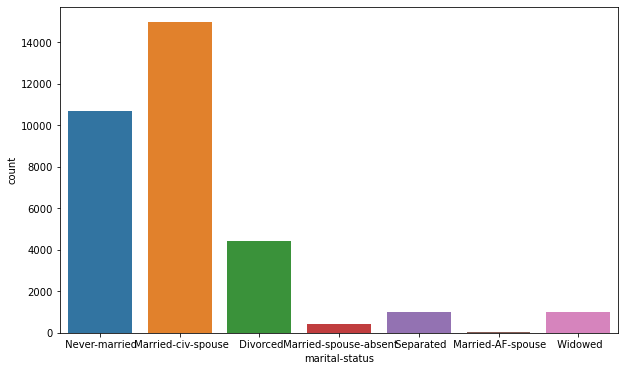

In [29]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = df['marital-status'])

In [30]:
df.replace(to_replace = [' Never-married', ' Divorced', ' Married-spouse-absent', ' Separated', ' Widowed'],
           value = ['Single', 'Single', 'Single', 'Single', 'Single'], inplace = True)
df.replace(to_replace = [' Married-civ-spouse', ' Married-AF-spouse'],
           value = ['Married', 'Married'], inplace = True)

<AxesSubplot:xlabel='marital-status', ylabel='count'>

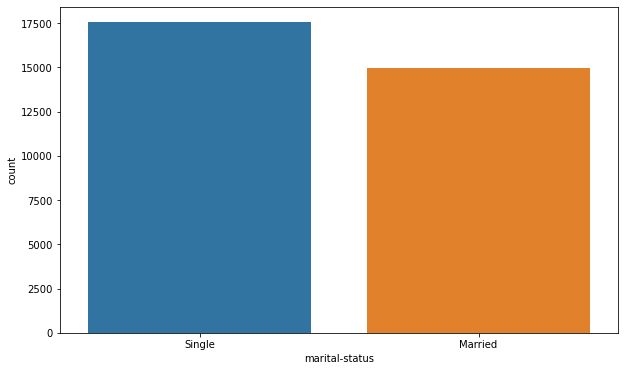

In [31]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = df['marital-status'])

In [32]:
df.replace(to_replace = ['Single', 'Married'],
           value = [0, 1], inplace = True)

In [33]:
df['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' Private', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

<AxesSubplot:xlabel='occupation', ylabel='count'>

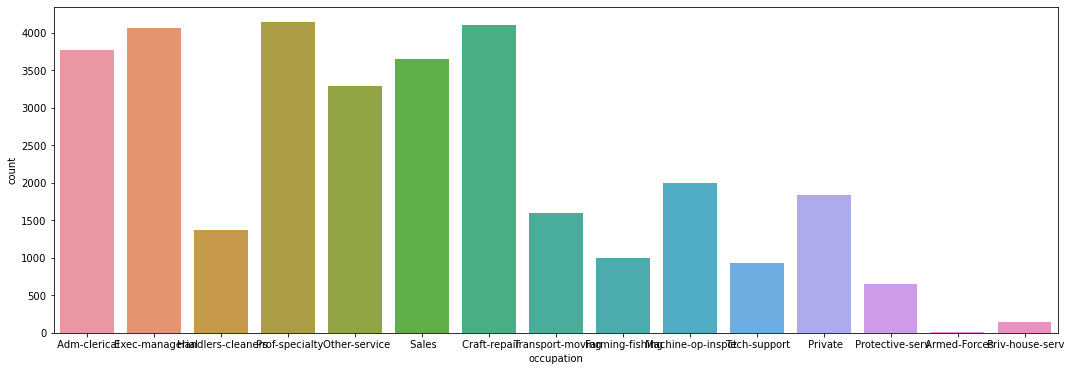

In [34]:
plt.figure(figsize = (18, 6))
sns.countplot(data = df, x = df['occupation'])

Performing one hot encoding on occupation feature

In [35]:
occupation_cols = pd.get_dummies(df['occupation'], drop_first = True)
occupation_cols.columns

Index([' Armed-Forces', ' Craft-repair', ' Exec-managerial',
       ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct',
       ' Other-service', ' Priv-house-serv', ' Private', ' Prof-specialty',
       ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'],
      dtype='object')

In [36]:
df['race'].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

<AxesSubplot:xlabel='race', ylabel='count'>

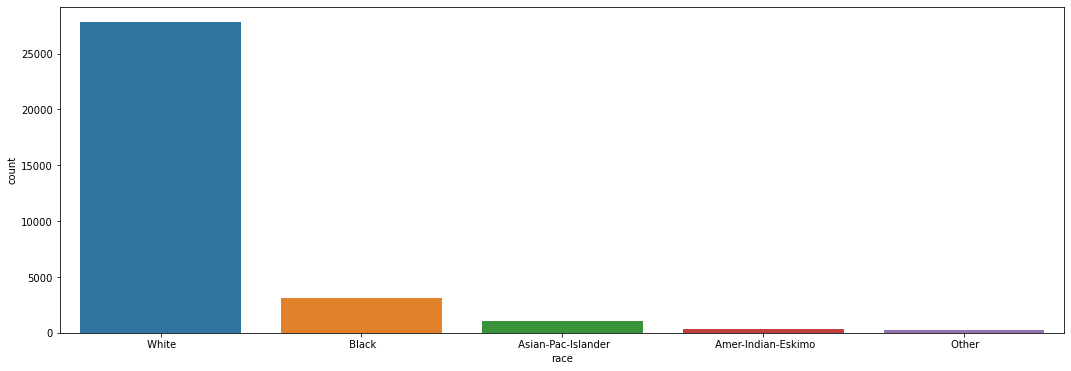

In [37]:
plt.figure(figsize = (18, 6))
sns.countplot(data = df, x = df['race'])

Performing one hot encoding on race feature

In [38]:
race_cols = pd.get_dummies(df['race'], drop_first = True)
race_cols.columns

Index([' Asian-Pac-Islander', ' Black', ' Other', ' White'], dtype='object')

In [39]:
df['country'].value_counts()

 United-States                 29170
 Mexico                          643
 Private                         583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [40]:
df['country'] = df['country'].apply(lambda x : 'Others' if x != ' United-States' else x)

In [41]:
df['country'].value_counts()

 United-States    29170
Others             3391
Name: country, dtype: int64

In [42]:
#Assigning 1 to US and 0 to Others
df.replace(to_replace = [' United-States', 'Others'], value = [1, 0], inplace = True)

In [43]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,4,13,0,Adm-clerical,Not-in-family,White,1,2174,0,40,1,<=50K
1,50,Self-emp-not-inc,83311,4,13,1,Exec-managerial,Husband,White,1,0,0,13,1,<=50K
2,38,Private,215646,5,9,0,Handlers-cleaners,Not-in-family,White,1,0,0,40,1,<=50K
3,53,Private,234721,2,7,1,Handlers-cleaners,Husband,Black,1,0,0,40,1,<=50K
4,28,Private,338409,4,13,1,Prof-specialty,Wife,Black,0,0,0,40,0,<=50K


In [44]:
df[(df['capital-gain'] > 0) & (df['capital-loss'] > 0)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary


In [45]:
df['gain/loss'] = abs(df['capital-gain'] - df['capital-loss'])

<AxesSubplot:xlabel='age', ylabel='Density'>

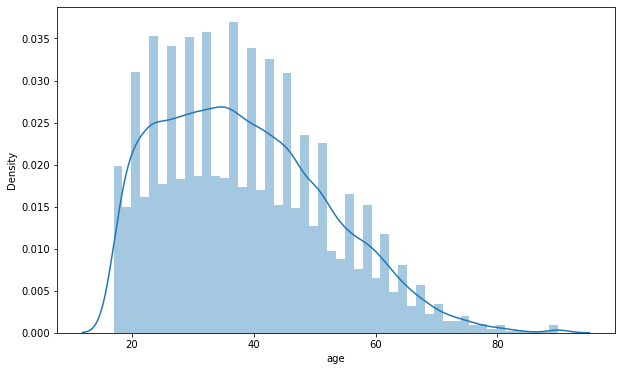

In [46]:
#age column
plt.figure(figsize = (10, 6))
sns.distplot(df['age'])

As we could see age is right skewed and not in normal distribution, let's treat with outlier treatment as most of
people are in the age range of 20 to 60

In [47]:
age_mean = df['age'].mean()
age_std = df['age'].std()

upper = age_mean + 3 * age_std
lower = age_mean - 3 * age_std

df = df[(df['age'] <= upper) & (df['age'] >= lower)]

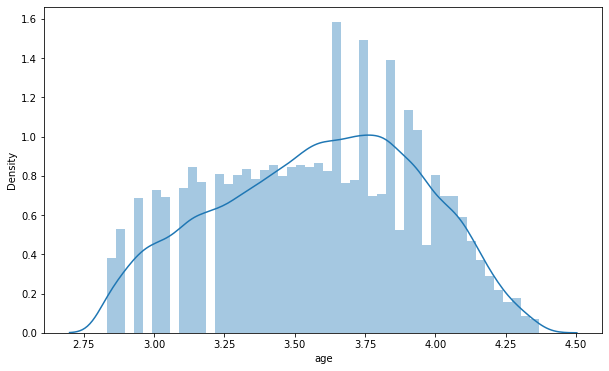

In [48]:
#Applying log transformation on age feature
df['age'] = np.log(df['age'])
plt.figure(figsize = (10, 6))
sns.distplot(df['age'])
plt.show()

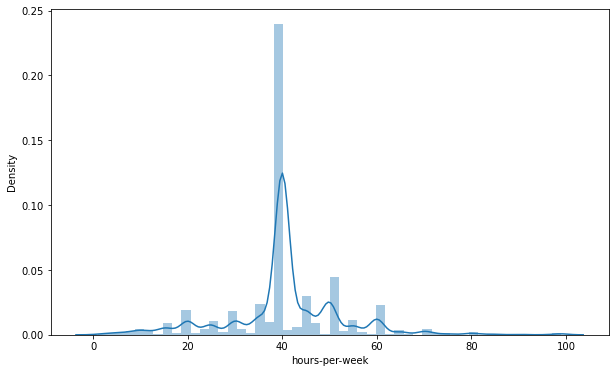

In [49]:
#hours-per-week column
plt.figure(figsize = (10, 6))
sns.distplot(df['hours-per-week'])
plt.show()

In [50]:
#Assigning 0 to <=50k and 1 to >50k
df.replace(to_replace = [' <=50K', ' >50K'], value = [0, 1], inplace = True)

In [51]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'salary',
       'gain/loss'],
      dtype='object')

In [52]:
df.drop(columns = ['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race',
                  'capital-gain', 'capital-loss'], inplace = True)

In [53]:
df.head()

,age,education,marital-status,sex,hours-per-week,country,salary,gain/loss
0,3.663562,4,0,1,40,1,0,2174
1,3.912023,4,1,1,13,1,0,0
2,3.637586,5,0,1,40,1,0,0
3,3.970292,2,1,1,40,1,0,0
4,3.332205,4,1,0,40,0,0,0


In [54]:
df = pd.concat([df, workclass_cols, occupation_cols, race_cols], axis = 1)

In [55]:
df.dropna(inplace = True)

In [56]:
df['education'] = df['education'].astype(int)
df['marital-status'] = df['marital-status'].astype(int)
df['sex'] = df['sex'].astype(int)
df['education'] = df['education'].astype(int)
df['hours-per-week'] = df['hours-per-week'].astype(int)
df['country'] = df['country'].astype(int)
df['salary'] = df['salary'].astype(int)
df['gain/loss'] = df['gain/loss'].astype(int)

In [57]:
df['gain/loss'] = np.log1p(df['gain/loss'])

In [58]:
df['gain/loss'] = df['gain/loss'].dropna()

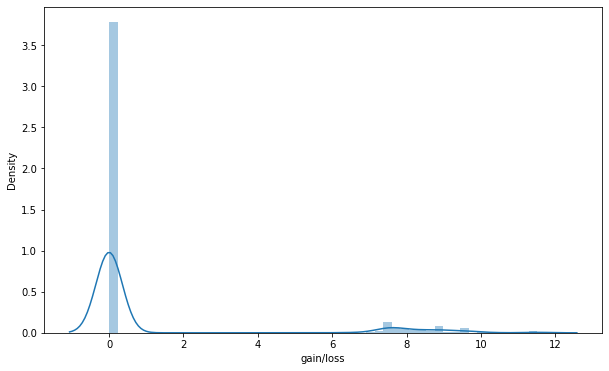

In [59]:
plt.figure(figsize = (10, 6))
sns.distplot(df['gain/loss'])
plt.show()

In [60]:
pd.set_option("display.max_columns",50)
df.head()

,age,education,marital-status,sex,hours-per-week,country,salary,gain/loss,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,No-Income,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Private,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Asian-Pac-Islander,Black,Other,White
0,3.663562,4,0,1,40,1,0,7.684784,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3.912023,4,1,1,13,1,0,0.000000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3.637586,5,0,1,40,1,0,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3.970292,2,1,1,40,1,0,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3.332205,4,1,0,40,0,0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [61]:
#Splitting dependent and independent features
X = df.drop(['salary'], axis = 1)
y = df['salary']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [110]:
y_train = y_train.values
y_test = y_test.values

# Using simple logistic regression model

In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
model = LogisticRegression(penalty = 'l2')

In [66]:
model.fit(X_train, y_train)

LogisticRegression()

In [67]:
model.score(X_test, y_test)

0.8377003699136868

# Using simple Randomforestclassifier

In [68]:
rf = RandomForestClassifier()

In [69]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
print(f'training score: {rf.score(X_train, y_train)}')
print(f'testing score: {rf.score(X_test, y_test)}')

training score: 0.9758014796547472
testing score: 0.8469482120838471


from above training score is more than testing score, so it is over fitting

# Check with gridsearchcv

In [71]:
fit_rf = RandomForestClassifier(random_state = 42)
param_dist = {'n_estimators': [50, 200, 400, 800],
             'max_depth': [4,6,10,12],
             'min_samples_split': [2, 5, 10, 15, 100],
             'min_samples_leaf': [1, 2, 5, 10],
             'criterion': ['gini', 'entropy']}

In [72]:
cv_rf = GridSearchCV(fit_rf,cv=10,param_grid=param_dist,n_jobs=-1)

In [123]:
cv_rf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 10, 12],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [50, 200, 400, 800]})

In [124]:
cv_rf.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [73]:
fit_rf.set_params(criterion = 'gini', max_depth = 12, min_samples_leaf = 1, min_samples_split = 2,
                  n_estimators = 200)

RandomForestClassifier(max_depth=12, n_estimators=200, random_state=42)

In [74]:
fit_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=200, random_state=42)

In [75]:
print(f'training score: {fit_rf.score(X_train, y_train)}')
print(f'testing score: {fit_rf.score(X_test, y_test)}')

training score: 0.8731889642416769
testing score: 0.8595869297163995


Let's go with randomforestclassifier with above set parameters

# Performance metrics

In [76]:
y_pred = fit_rf.predict(X_test)

<AxesSubplot:>

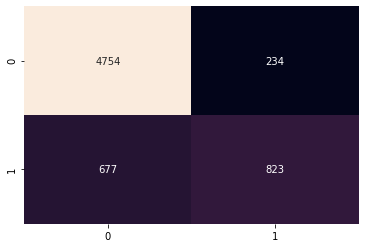

In [77]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='d', cbar=False)

In [78]:
print('recall :', recall_score(y_test, y_pred))
print('precision :', precision_score(y_test, y_pred))
print('F1 :', f1_score(y_test, y_pred))
print('accuracy :', accuracy_score(y_test, y_pred))

recall : 0.5486666666666666
precision : 0.7786187322611163
F1 : 0.6437231130230738
accuracy : 0.8595869297163995


# SMOTETomek

As recall score is not good i.e., most of the postive classes were predicted wrong, and initially as we see there
is imbalance in data, let's use SMOTETomek to work on imbalance data

In [94]:
X_train = X_train.values

In [96]:
st = SMOTETomek(0.8)
X_train_st, y_train_st = st.fit_sample(X_train, y_train)

Increasing less class data to 80% of higher class data

In [97]:
Counter(y_train_st)

Counter({0: 18944, 1: 15018})

In [98]:
fit_rf_st = RandomForestClassifier()
param_dist_st = {'n_estimators': [50, 200, 400, 800],
             'max_depth': [4,6,10,12],
             'min_samples_split': [2, 5, 10, 15, 100],
             'min_samples_leaf': [1, 2, 5, 10],
             'criterion': ['gini', 'entropy']}

In [99]:
cv_rf_st = GridSearchCV(fit_rf_st,cv=10,param_grid=param_dist_st,n_jobs=-1)

In [110]:
cv_rf_st.fit(X_train_st, y_train_st)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 10, 12],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [50, 200, 400, 800]})

In [111]:
cv_rf_st.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [100]:
fit_rf_st.set_params(criterion = 'gini', max_depth = 12, min_samples_leaf = 1, min_samples_split = 2,
                  n_estimators = 50)

RandomForestClassifier(max_depth=12, n_estimators=50)

In [101]:
fit_rf_st.fit(X_train_st, y_train_st)

RandomForestClassifier(max_depth=12, n_estimators=50)

In [102]:
print(f'training score: {fit_rf_st.score(X_train_st, y_train_st)}')
print(f'testing score: {fit_rf_st.score(X_test, y_test)}')

training score: 0.8863730051233731
testing score: 0.8304562268803946


In [111]:
y_pred = fit_rf_st.predict(X_test)

<AxesSubplot:>

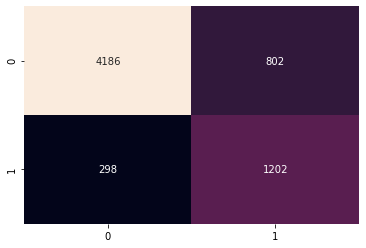

In [112]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='d', cbar=False)

In [113]:
print('recall :', recall_score(y_test, y_pred))
print('precision :', precision_score(y_test, y_pred))
print('F1 :', f1_score(y_test, y_pred))
print('accuracy :', accuracy_score(y_test, y_pred))

recall : 0.8013333333333333
precision : 0.5998003992015968
F1 : 0.6860730593607306
accuracy : 0.8304562268803946


In [108]:
#Saving the model
joblib.dump(fit_rf_st, 'adult_income81.pkl')

['adult_income81.pkl']